In [1]:
#Implementieren Sie das Perzeptron (aus dem vorigen Übungsblatt) mit PyTorch 
#(aber ohne das fertige Perceptron-Modell zu verwenden).
# Implementieren Sie Training über mehrere Epochen und testen Sie Ihre Implementierung 
# auf einem mit sklearn.datasets.make_moons erstellten Datensatz.
# Visualisieren Sie das Ergebnis geeignet mit matplotlib.
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

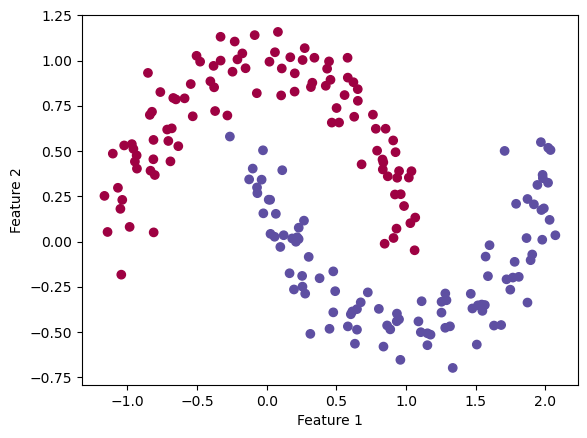

In [2]:
## Datensatz erstellen ##
X,y = make_moons(n_samples = 200, noise = 0.1, random_state=0)

# visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Perceptron:

    def loss(ys_true, ys_pred):
        assert ys_true.shape == ys_pred.shape
        return torch.mean((ys_pred != ys_true).float())
    
    def __init__(self, weight_vector=None, learn_rate=0.01):
        if weight_vector is not None:
            self.weight_vector = torch.tensor(weight_vector, dtype=torch.float32, device = device)
        else:
            self.weight_vector = None
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)  # Initialize bias to 0
        self.learn_rate = learn_rate

    
    # Checks if the model has been fitted before making predictions.
    def assume_fitted(self):
        if self.weight_vector is None:
            raise RuntimeError("tried to predict without fit")
        
    # Makes predictions on input features.
    def predict(self, xs):
        self.assume_fitted()
        return self._predict(xs)
    
    # Computes the dot product of input features and weight vector, adds bias, then applies the step function.
    def _predict(self, xs):
        return (torch.matmul(xs, self.weight_vector) + self.bias > 0).float()

    # Updates the weight vector and bias based on a single training example.
    def _single_update(self, x, y):
        pred = self._predict(x.unsqueeze(0))
        loss = y - pred
        self.weight_vector += self.learn_rate * loss * x
        self.bias += self.learn_rate * loss  # Update bias according to the new rule
        self.weight_vector /= torch.norm(self.weight_vector)
    
    # Updates the weight vector and bias based on each training example, for a number of epochs.
    def fit(self, xs, ys, epochs=1):
        assert xs.shape[0] == ys.shape[0]

        if self.weight_vector is None:
            self.weight_vector = torch.ones(xs.shape[1])
        
        previous_loss = l = 1
        for _ in range(epochs):
            for x, y in zip(xs, ys):
                self._single_update(x, y)
            previous_loss = l
            l = Perceptron.loss(ys, self._predict(xs))

    # Returns the slope and intercept of the decision boundary.
    def get_decision_boundary(self):
        self.assume_fitted()
        slope = -self.weight_vector[0] / self.weight_vector[1]
        intercept = -self.bias / self.weight_vector[1]
        return slope.item(), intercept.item()


In [4]:
def plot_prediction_with_boundary(xs, ys, epochs=200, perceptron=None):
    if perceptron is None:
        perceptron = Perceptron(learn_rate=0.01)

    # Convert numpy arrays to PyTorch tensors and move to the device
    X_tensor = torch.tensor(xs, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(ys, dtype=torch.float32, device=device)

    # Fit the model
    perceptron.fit(X_tensor, y_tensor, epochs=epochs)
    
    # Get the decision boundary
    slope, intercept = perceptron.get_decision_boundary()
    print("Current loss:", Perceptron.loss(y_tensor, perceptron.predict(X_tensor)).item())
    
    xmin, xmax = np.min(xs[:,0]), np.max(xs[:,0])
    ymin, ymax = np.min(xs[:,1]), np.max(xs[:,1])
    smallest = np.min([xmin, ymin]) - 1
    biggest = np.max([np.abs(xmax-xmin), np.abs(ymax-ymin)]) + 2
    xlim = (smallest, smallest + biggest)
    ylim = (smallest, smallest + biggest)
    
    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlim=xlim, ylim=ylim)
    ax.scatter(xs[:,0], xs[:,1], c=ys)
    ax.plot(np.linspace(smallest, biggest, 2),
            slope * np.linspace(smallest, biggest, 2) + intercept)
    plt.show()

Current loss: 0.39500001072883606


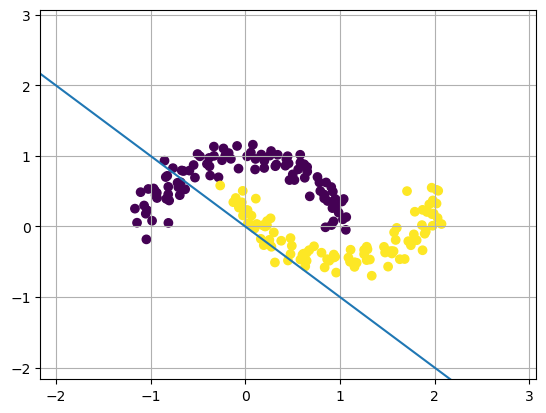

Current loss: 0.4749999940395355


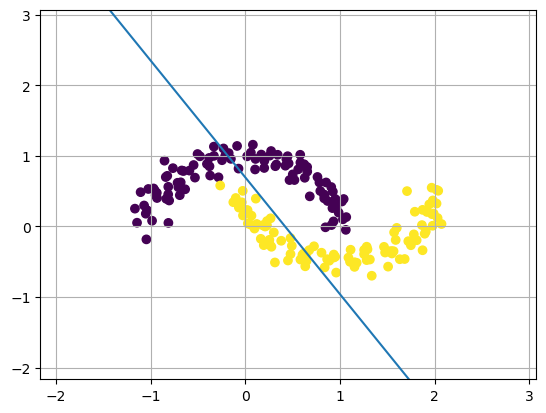

Current loss: 0.36500000953674316


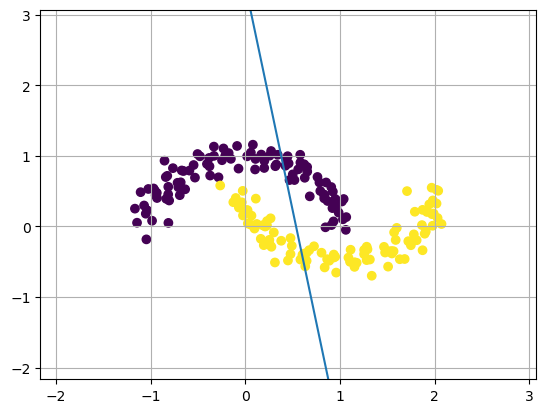

Current loss: 0.2800000011920929


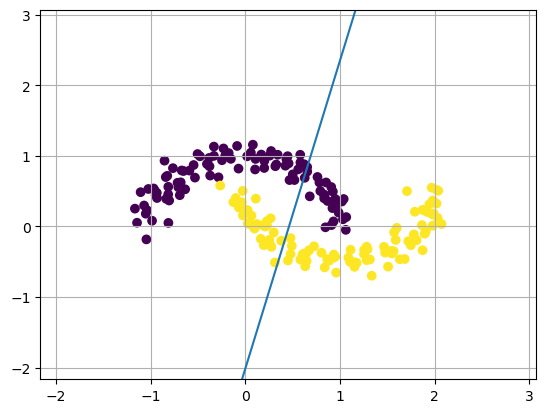

Current loss: 0.2150000035762787


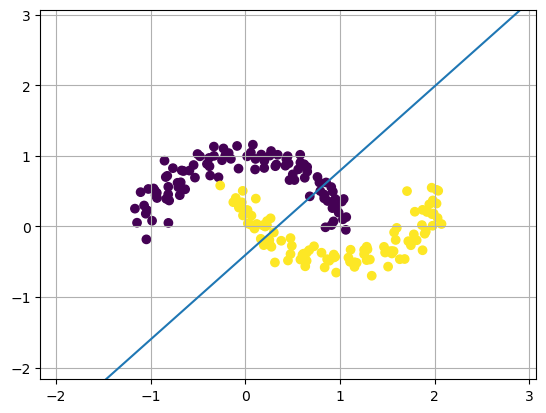

Current loss: 0.11999999731779099


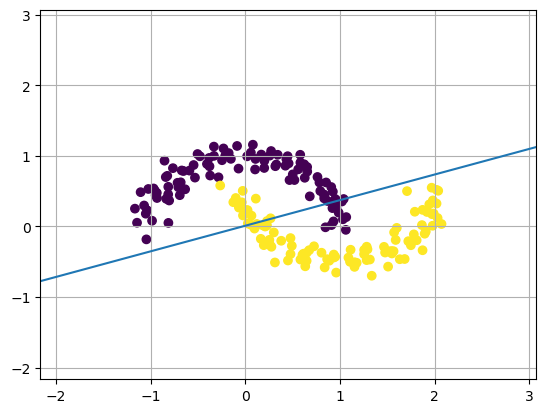

Current loss: 0.125


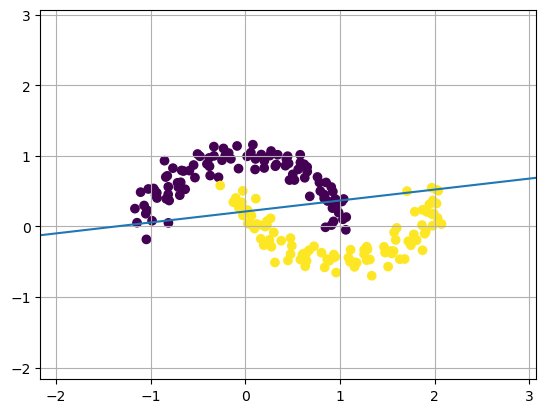

Current loss: 0.11999999731779099


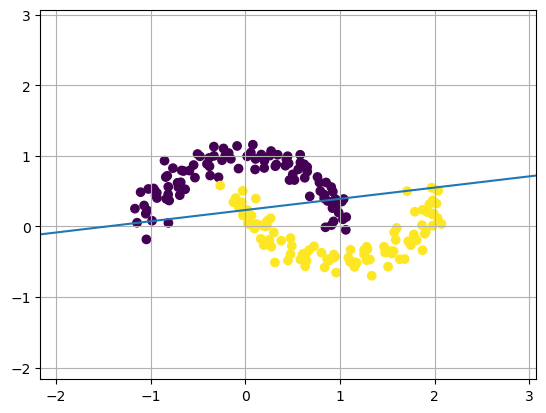

Current loss: 0.11999999731779099


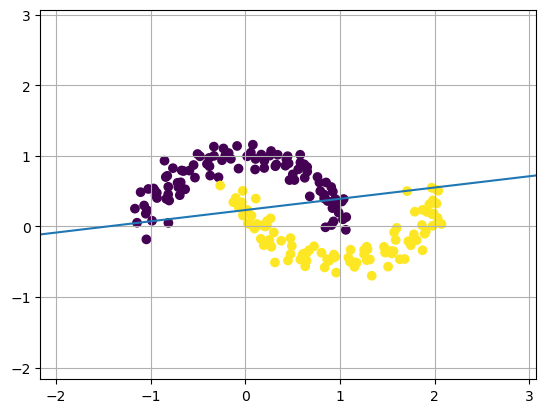

Current loss: 0.11999999731779099


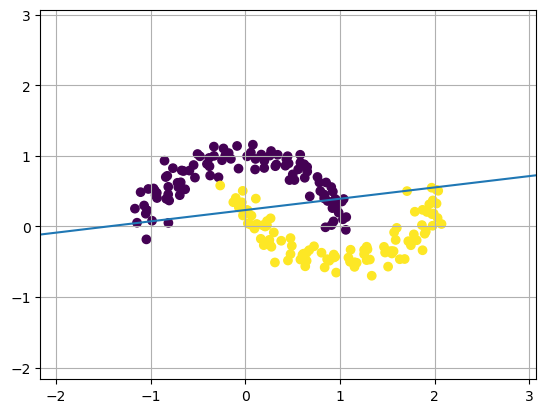

In [5]:
P = Perceptron(learn_rate=0.01)

for e in range(10):
    plot_prediction_with_boundary(X, y, epochs=e, perceptron=P)